In [1]:
%matplotlib notebook

In [2]:
# Purpose of this notebook: test LSTM model on SPY data 
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


In [113]:
# convert p_t into a X,Y matrices for classification task
def make_dataset(p_t, dt_back=1):
    dataX, dataY = [], []
    
    for i in range(len(p_t)-dt_back-1):
        a = p_t[i:(i+dt_back), 0]
        dataX.append(a)
        dataY.append(p_t[i + dt_back, 0])
    # end for i
    
    # reshape X to be in the form [samples, time steps, features] - standard input for LSTM
    X=np.array(dataX)
    X = np.reshape(X,(X.shape[0],X.shape[1],1))  
    
    di=0; dj=0;   # i need this to be consistent with make_batch_dataset signature
    
    return X,np.array(dataY),di,dj
#end def make_dataset

# create dataset with the shapes divisible by batch_size, this is needed for stateful LSTM
def make_batch_dataset(p_t,dt_back=1,batch_size=1):
    X,Y,dn,dm = make_dataset(p_t,dt_back);
    di=np.mod(len(X),batch_size);    dj=np.mod(len(Y),batch_size);
    
    return X[:-di],Y[:-dj],di,dj
#end def  X,Y,di,dj=make_batch_dataset(p_t,dt_back,batch_size)

# create and fit the LSTM network
def make_model(dt_back=10,n_epoch=5):
    print('=== make_model: n_layer=',1,', dt_back=',dt_back,', n_epoch=',n_epoch,' ===')
    model = Sequential()
    model.add(LSTM(100, input_shape=(dt_back,1)))   # input_shape=(1, dt_back)
    model.add(Dense(1))

    # compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model    
# end def make_model():

# create a 1-layer model with batch_size to define stateful LSTM model   # "bmodel"=batch-model
def make_bmodel(dt_back=10,n_epoch=5,batch_size=1,stateful=False):    
    print('=== make_bmodel: n_layer=',1,', dt_back=',dt_back,', n_epoch=',n_epoch,', Nb=',batch_size,' ===')
    
    model = Sequential()
    model.add(LSTM(100,batch_input_shape=(batch_size,dt_back,1),stateful=stateful))   # input_shape=(dt_back,1)  , activation='relu')
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_bmodel():

# create a 1-layer model with batch_size to define stateful LSTM model
def make_bmodel_1(dt_back=10,n_epoch=5,batch_size=1,stateful=False):    
    print('=== make_bmodel_1: n_layer=',1,', dt_back=',dt_back,', n_epoch=',n_epoch,', Nb=',batch_size,' ===')
    
    model = Sequential()
    model.add(LSTM(100,batch_input_shape=(batch_size,dt_back,1),stateful=stateful))   # input_shape=(dt_back,1)  , activation='relu')
    
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_bmodel():

# create a 2-layer model with batch_size to define stateful LSTM model
def make_bmodel_2(dt_back=10,n_epoch=5,batch_size=1,stateful=False):    
    print('=== make_bmodel_2: n_layer=',2,', dt_back=',dt_back,', n_epoch=',n_epoch,', Nb=',batch_size,' ===')
    
    model = Sequential()
    model.add(LSTM(100,batch_input_shape=(batch_size,dt_back,1),stateful=stateful,return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')
    model.add(Dropout(0.2))
    
    model.add(LSTM(100,stateful=stateful,return_sequences=False))
    
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_bmodel():

# create a 3-layer model with batch_size to define stateful LSTM model
def make_bmodel_3(dt_back=10,n_epoch=5,batch_size=1,stateful=False):    
    print('=== make_bmodel_3: n_layer=',3,', dt_back=',dt_back,', n_epoch=',n_epoch,', Nb=',batch_size,' ===')
    
    model = Sequential()
    model.add(LSTM(100,batch_input_shape=(batch_size,dt_back,1),stateful=stateful,return_sequences=True))   # input_shape=(dt_back,1)  , activation='relu')
    model.add(Dropout(0.2))
    model.add(LSTM(100,stateful=stateful,return_sequences=True))     # ,input_shape=(dt_back,1),return_sequences=False
    model.add(Dropout(0.2))
    
    model.add(LSTM(100,stateful=stateful,return_sequences=False))
    
    model.add(Dense(1))                             # , activation='sigmoid'
    model.compile(loss='mean_squared_error', optimizer='adam')   # loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']
    
    return model
# end def make_bmodel():

In [102]:
# fix random seed for reproducibility
np.random.seed(7)

# load the p_t
df = read_csv('sp500.csv', usecols=[0], engine='python', skipfooter=3)
p_t = df.values       
p_t = p_t.astype('float32')

In [17]:
batch_size=11   #p_t.shape   #df.values
di=np.mod(len(p_t),batch_size)

pb_t=p_t[:-di]

N_train=int(len(pb_t) * 0.67); di=np.mod(N_train,batch_size); N_train=N_train-di; 

p_t=pb_t;   # print(p_t.shape,N_train); # np.mod(len(pb_t)-N_train,batch_size)    #   (N_train-di)/  # print(di)


In [18]:
# normalize the p_t
scaler = MinMaxScaler(feature_range=(0, 1))
p_t = scaler.fit_transform(p_t)

# split into train and test sets with sizes divisible by batch_size
N_train = int(len(p_t) * 0.67); di=np.mod(N_train,batch_size); N_train=N_train-di; 
N_test = len(p_t) - N_train
train, test = p_t[0:N_train,:], p_t[N_train:len(p_t),:]

# check sizes
di1=np.mod(len(train),batch_size); di2=np.mod(len(test),batch_size); di3=np.mod(len(p_t),batch_size);   
print(batch_size,len(train),len(test),len(p_t),di1,di2,di3)   

11 2761 1375 4136 0 0 0


In [93]:
#if stateful: f_state=1    #batch_size    #model=make_model(dt_back,n_epoch)
int(stateful)    

1

In [94]:
# reshape into X=[t-dt_back,t-dt_back+1,...,t] and Y=t+1
dt_back=33     #99;   # look back time period
nlayer=1;
n_epoch=15;    # 5;   #
stateful=True;   # False;  #

trainX,trainY,di,dj=make_batch_dataset(train,dt_back,batch_size); #trainX,trainY,di,dj=make_dataset(train,dt_back);    
testX,testY,di1,dj1=make_batch_dataset(test,dt_back,batch_size);    #testX,testY,di,dj=make_dataset(test,dt_back);

#print(trainX.shape,testX.shape,di,dj,di1,dj1,np.mod(len(trainX),batch_size),np.mod(len(trainY),batch_size))   

# construct and train model
#model=make_model(dt_back=dt_back,n_epoch);
model=make_bmodel(dt_back,n_epoch,batch_size,stateful);
           
model.fit(trainX,trainY,epochs=n_epoch,batch_size=batch_size,verbose=2)   # , epochs=5

# make predictions
trainPredict = model.predict(trainX,batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)

=== make_batch_model: n_layer= 1 , dt_back= 33 , n_epoch= 15 , Nb= 11  ===
Epoch 1/15
4s - loss: 0.0030
Epoch 2/15
2s - loss: 3.0723e-04
Epoch 3/15
3s - loss: 3.0140e-04
Epoch 4/15
2s - loss: 2.7810e-04
Epoch 5/15
2s - loss: 2.4047e-04
Epoch 6/15
2s - loss: 2.3567e-04
Epoch 7/15
2s - loss: 2.2238e-04
Epoch 8/15
3s - loss: 2.2100e-04
Epoch 9/15
2s - loss: 2.2906e-04
Epoch 10/15
2s - loss: 1.8989e-04
Epoch 11/15
2s - loss: 1.7682e-04
Epoch 12/15
2s - loss: 1.7934e-04
Epoch 13/15
2s - loss: 1.6428e-04
Epoch 14/15
3s - loss: 1.5011e-04
Epoch 15/15
2s - loss: 1.4147e-04


In [95]:
# invert predictions
p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);
p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))
testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))

print('-----------')    # '\n'
print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))

#print(len(p_t),N_train,len(trainX),N_test,len(testX),len(p_test_pred_t))   #len(p_train_pred_t)  #.shape   #/11
#print(N_train - len(trainX),N_test-len(testX))

-----------
Train Score: 17.17 RMSE
Test Score: 19.73 RMSE


<IPython.core.display.Javascript object>


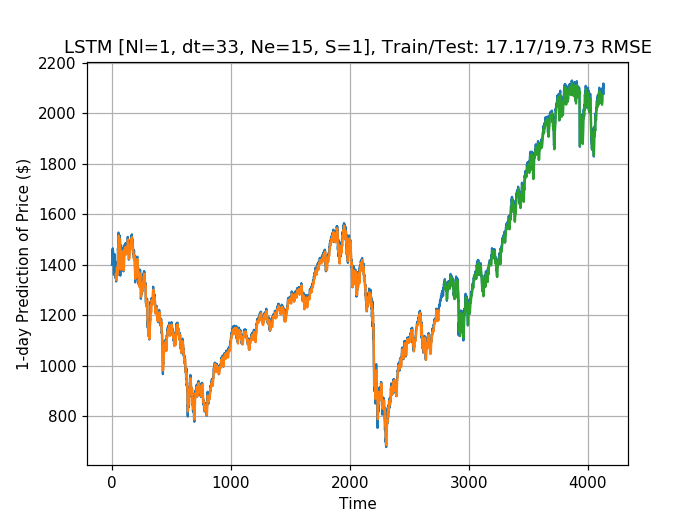

In [96]:
# shift train predictions for plotting
p_train_pred_pl_t = np.empty_like(p_t)
p_train_pred_pl_t[:, :] = np.nan
p_train_pred_pl_t[dt_back:len(p_train_pred_t)+dt_back, :] = p_train_pred_t

# shift test predictions for plotting
p_test_pred_pl_t = np.empty_like(p_t)
p_test_pred_pl_t[:, :] = np.nan;    
ti1=len(p_train_pred_t)+(dt_back*2)+di+1;  ti2=ti1+len(p_test_pred_t);        
p_test_pred_pl_t[ti1:ti2, :] = p_test_pred_t  

trainY2 = np.reshape(trainY1,(trainY1.shape[1],trainY1.shape[0]))   #np.array(trainY1)   #.shape

p_pl_t=scaler.inverse_transform(p_t)

# plot baseline and predictions
fig1 = plt.figure()

plt.plot(p_pl_t)   # (trainY2)   # [2700:2900]
plt.plot(p_train_pred_pl_t)   #(p_train_pred_t)    # [2700:2900]
plt.plot(p_test_pred_pl_t)    # [2700:2900]

s_score='Train/Test: %.2f/%.2f RMSE' % (trainScore,testScore);
s_title='LSTM [Nl=' + str(nlayer) + ', dt=' + str(dt_back) + ', Ne=' + str(n_epoch) + ', S=' + str(int(stateful)) + '], ' + s_score
plt.title(s_title)
plt.ylabel('1-day Prediction of Price ($)')
plt.xlabel('Time') 

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


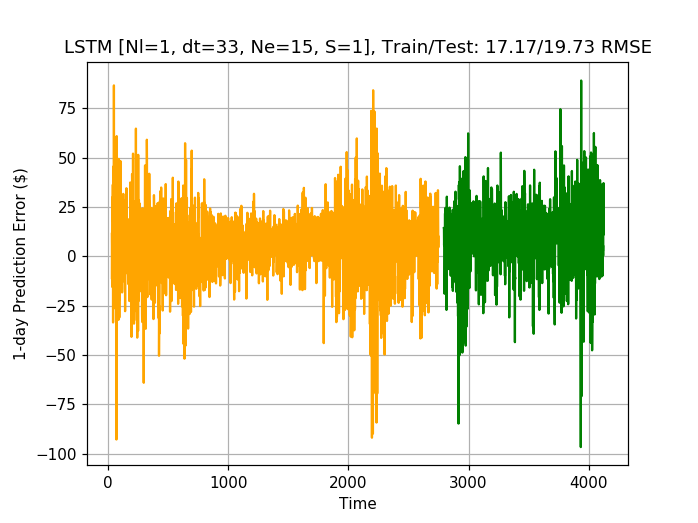

In [97]:
# plot prediction errors
fig2 = plt.figure()

plt.plot(p_pl_t-p_train_pred_pl_t,color='orange')   # (trainY2)   # [2700:2900]
plt.plot(p_pl_t-p_test_pred_pl_t,color='green') 

s_score='Train/Test: %.2f/%.2f RMSE' % (trainScore,testScore);
s_title='LSTM [Nl=' + str(nlayer) + ', dt=' + str(dt_back) + ', Ne=' + str(n_epoch) + ', S=' + str(int(stateful)) + '], ' + s_score
plt.title(s_title)
plt.ylabel('1-day Prediction Error ($)')
plt.xlabel('Time') 

plt.grid()
plt.show()

In [106]:
# need to summarize all the training/testing/plotting steps to vary the model parameters
def train_plot_model(p_t,make_bmodel,nlayer,train,test,dt_back,n_epoch=5,batch_size=11,stateful=False,verbose=0):
    # adjust the size of p_t to be divisible by batch_size
    di=np.mod(len(p_t),batch_size)
    pb_t=p_t[:-di]; N_train=int(len(pb_t) * 0.67); di=np.mod(N_train,batch_size); N_train=N_train-di; 
    p_t=pb_t;   # print(p_t.shape,N_train); # np.mod(len(pb_t)-N_train,batch_size)    #   (N_train-di)/  # print(di)

    # normalize the p_t
    scaler = MinMaxScaler(feature_range=(0, 1))
    p_t = scaler.fit_transform(p_t)

    # split into train and test sets with sizes divisible by batch_size
    N_train = int(len(p_t) * 0.67); di=np.mod(N_train,batch_size); N_train=N_train-di; 
    N_test = len(p_t) - N_train
    train, test = p_t[0:N_train,:], p_t[N_train:len(p_t),:]    

    trainX,trainY,di,dj=make_batch_dataset(train,dt_back,batch_size); #trainX,trainY,di,dj=make_dataset(train,dt_back);    
    testX,testY,di1,dj1=make_batch_dataset(test,dt_back,batch_size);    #testX,testY,di,dj=make_dataset(test,dt_back);

    # construct and train model
    model=make_bmodel(dt_back,n_epoch,batch_size,stateful);

    model.fit(trainX,trainY,epochs=n_epoch,batch_size=batch_size,verbose=verbose)   # , epochs=5

    # make predictions
    trainPredict = model.predict(trainX,batch_size=batch_size)
    testPredict = model.predict(testX,batch_size=batch_size)    

    # invert predictions
    p_train_pred_t = scaler.inverse_transform(trainPredict); trainY1 = scaler.inverse_transform([trainY]);
    p_test_pred_t = scaler.inverse_transform(testPredict);   testY1 = scaler.inverse_transform([testY]);

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY1[0], p_train_pred_t[:,0]))
    testScore = math.sqrt(mean_squared_error(testY1[0], p_test_pred_t[:,0]))

    # shift train predictions for plotting
    p_train_pred_pl_t = np.empty_like(p_t)
    p_train_pred_pl_t[:, :] = np.nan
    p_train_pred_pl_t[dt_back:len(p_train_pred_t)+dt_back, :] = p_train_pred_t

    # shift test predictions for plotting
    p_test_pred_pl_t = np.empty_like(p_t)
    p_test_pred_pl_t[:, :] = np.nan;    
    ti1=len(p_train_pred_t)+(dt_back*2)+di+1;  ti2=ti1+len(p_test_pred_t);        
    p_test_pred_pl_t[ti1:ti2, :] = p_test_pred_t  

    trainY2 = np.reshape(trainY1,(trainY1.shape[1],trainY1.shape[0]))   #np.array(trainY1)   #.shape

    p_pl_t=scaler.inverse_transform(p_t)

    # plot baseline and predictions
    fig1 = plt.figure()

    plt.plot(p_pl_t)   # (trainY2)   # [2700:2900]
    plt.plot(p_train_pred_pl_t)   #(p_train_pred_t)    # [2700:2900]
    plt.plot(p_test_pred_pl_t)    # [2700:2900]

    s_score='Train/Test: %.2f/%.2f RMSE' % (trainScore,testScore);
    s_title='LSTM [Nl=' + str(nlayer) + ', dt=' + str(dt_back) + ', Ne=' + str(n_epoch) + ', S=' + str(int(stateful)) + '], ' + s_score
    plt.title(s_title)
    plt.ylabel('1-day Prediction of Price ($)')
    plt.xlabel('Time') 

    plt.grid()
    plt.show()
    
    # plot prediction errors
    fig2 = plt.figure()

    plt.plot(p_pl_t-p_train_pred_pl_t,color='orange')   # (trainY2)   # [2700:2900]
    plt.plot(p_pl_t-p_test_pred_pl_t,color='green') 

    s_score='Train/Test: %.2f/%.2f RMSE' % (trainScore,testScore);
    s_title='LSTM [Nl=' + str(nlayer) + ', dt=' + str(dt_back) + ', Ne=' + str(n_epoch) + ', S=' + str(int(stateful)) + '], ' + s_score
    plt.title(s_title)
    plt.ylabel('1-day Prediction Error ($)')
    plt.xlabel('Time') 

    plt.grid()
    plt.show()

    return trainScore,testScore
#end def train_plot_model

In [101]:
p_t.shape

(4136, 1)

=== make_bmodel: n_layer= 1 , dt_back= 99 , n_epoch= 15 , Nb= 11  ===
Epoch 1/15
9s - loss: 0.0031
Epoch 2/15
8s - loss: 3.1037e-04
Epoch 3/15
8s - loss: 2.9695e-04
Epoch 4/15
8s - loss: 2.6212e-04
Epoch 5/15
8s - loss: 2.6318e-04
Epoch 6/15
8s - loss: 2.4181e-04
Epoch 7/15
8s - loss: 2.1988e-04
Epoch 8/15
8s - loss: 1.9651e-04
Epoch 9/15
8s - loss: 2.0742e-04
Epoch 10/15
8s - loss: 1.8091e-04
Epoch 11/15
8s - loss: 1.7057e-04
Epoch 12/15
8s - loss: 1.5764e-04
Epoch 13/15
8s - loss: 1.5158e-04
Epoch 14/15
8s - loss: 1.4698e-04
Epoch 15/15
8s - loss: 1.4320e-04


<IPython.core.display.Javascript object>


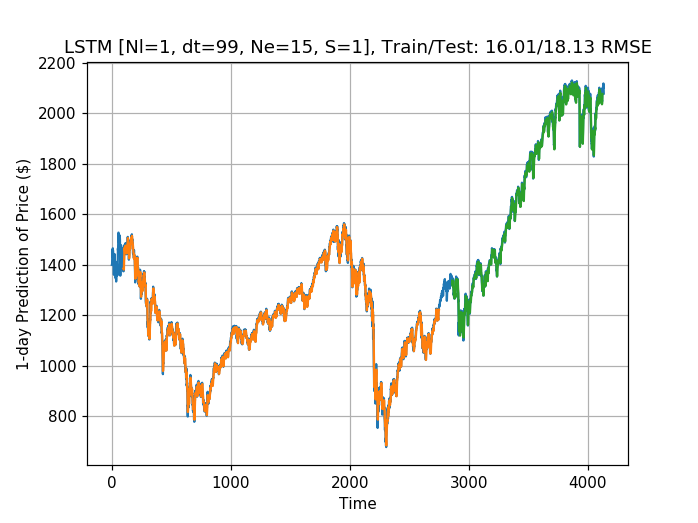

<IPython.core.display.Javascript object>


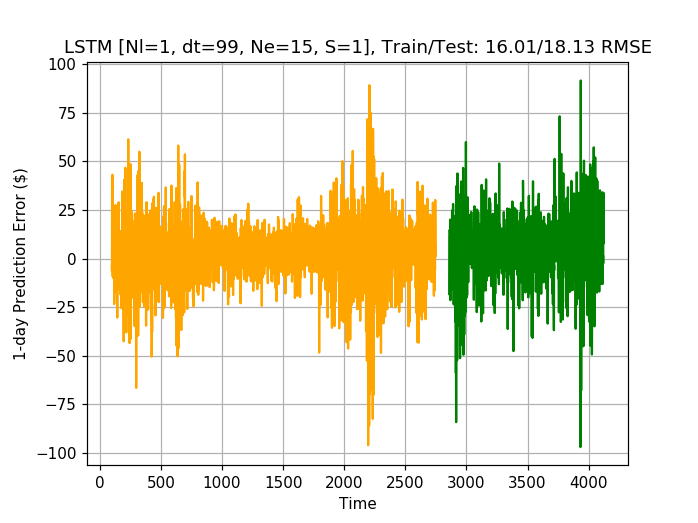

(16.006188734327907, 18.127483635319916)

In [103]:
stateful=True
nlayer=1         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=99
n_epoch=15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful)

=== make_bmodel_2: n_layer= 2 , dt_back= 99 , n_epoch= 25 , Nb= 11  ===


<IPython.core.display.Javascript object>


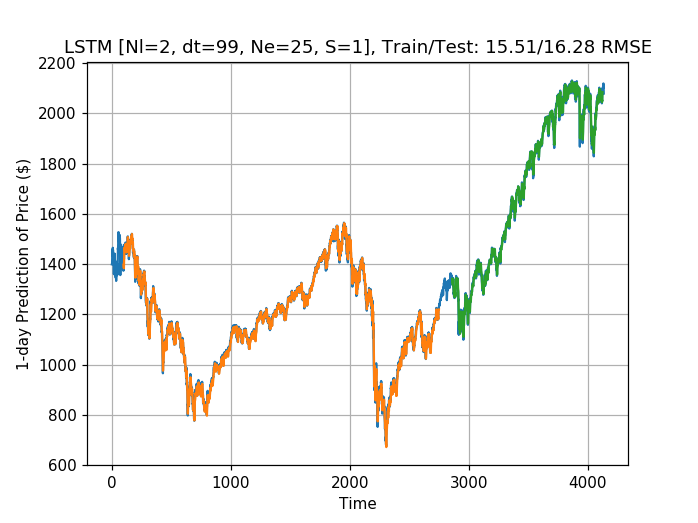

<IPython.core.display.Javascript object>


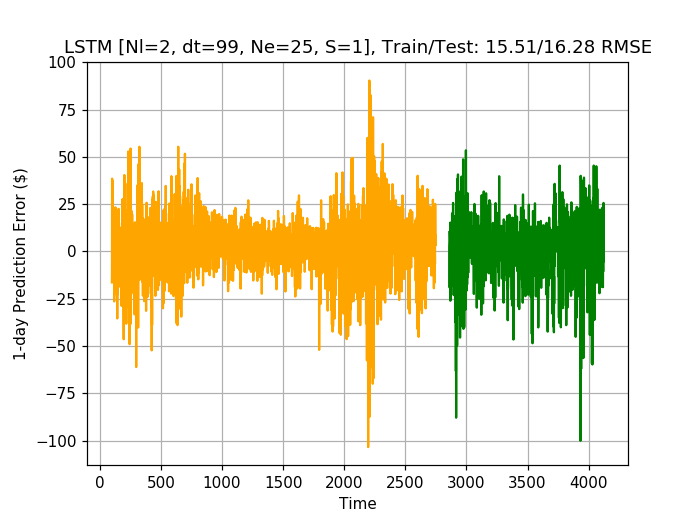

(15.513861795549785, 16.283244104825613)

In [107]:
stateful=True
nlayer=2         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=99
n_epoch=25;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful)

=== make_bmodel_2: n_layer= 2 , dt_back= 99 , n_epoch= 35 , Nb= 11  ===
Epoch 1/35
20s - loss: 0.0025
Epoch 2/35
18s - loss: 4.6181e-04
Epoch 3/35
18s - loss: 4.4124e-04
Epoch 4/35
18s - loss: 3.6291e-04
Epoch 5/35
18s - loss: 3.4542e-04
Epoch 6/35
18s - loss: 3.3562e-04
Epoch 7/35
18s - loss: 3.2755e-04
Epoch 8/35
18s - loss: 2.6788e-04
Epoch 9/35
18s - loss: 2.7352e-04
Epoch 10/35
18s - loss: 2.4591e-04
Epoch 11/35
18s - loss: 2.4043e-04
Epoch 12/35
18s - loss: 2.3834e-04
Epoch 13/35
18s - loss: 2.0990e-04
Epoch 14/35
18s - loss: 2.0422e-04
Epoch 15/35
18s - loss: 2.1971e-04
Epoch 16/35
18s - loss: 2.0821e-04
Epoch 17/35
18s - loss: 1.9100e-04
Epoch 18/35
18s - loss: 1.9323e-04
Epoch 19/35
18s - loss: 1.7563e-04
Epoch 20/35
18s - loss: 1.8124e-04
Epoch 21/35
18s - loss: 1.8869e-04
Epoch 22/35
18s - loss: 1.7244e-04
Epoch 23/35
18s - loss: 1.7645e-04
Epoch 24/35
18s - loss: 1.7261e-04
Epoch 25/35
18s - loss: 1.6040e-04
Epoch 26/35
18s - loss: 1.7307e-04
Epoch 27/35
18s - loss: 1.6558e

<IPython.core.display.Javascript object>


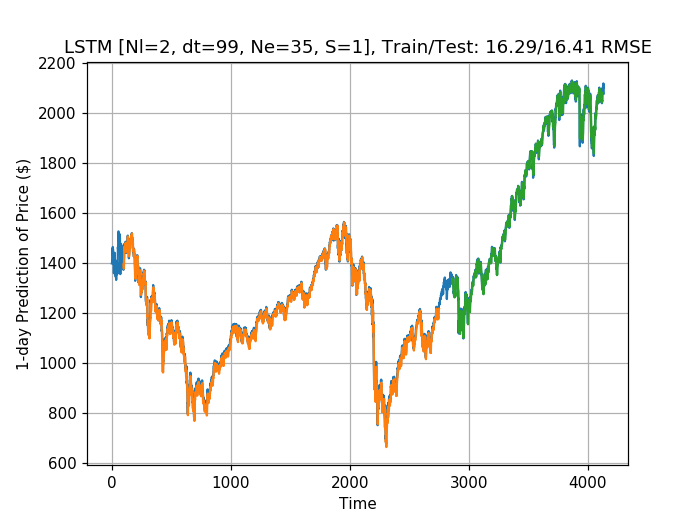

<IPython.core.display.Javascript object>


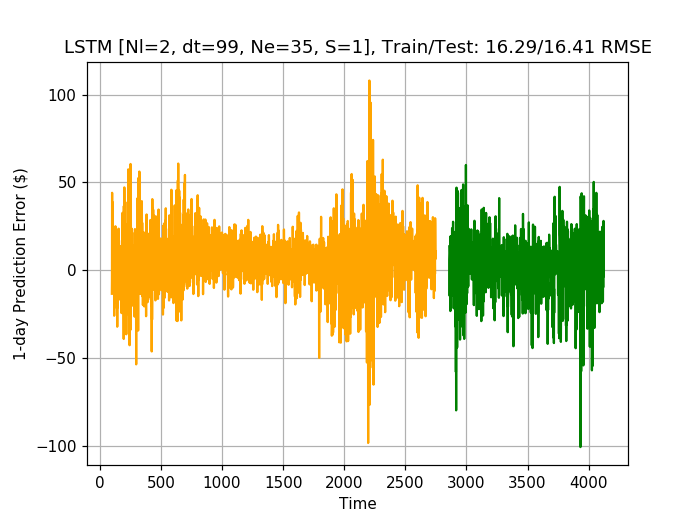

(16.285104770029342, 16.41100544188804)

In [108]:
stateful=True
nlayer=2         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=99
n_epoch=35;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful,verbose=2)

=== make_bmodel_2: n_layer= 2 , dt_back= 165 , n_epoch= 50 , Nb= 11  ===
Epoch 1/50
32s - loss: 0.0027
Epoch 2/50
30s - loss: 4.5626e-04
Epoch 3/50
30s - loss: 4.0971e-04
Epoch 4/50
30s - loss: 3.5206e-04
Epoch 5/50
30s - loss: 3.6946e-04
Epoch 6/50
30s - loss: 3.1174e-04
Epoch 7/50
30s - loss: 3.3809e-04
Epoch 8/50
30s - loss: 3.1749e-04
Epoch 9/50
30s - loss: 2.6249e-04
Epoch 10/50
30s - loss: 2.5052e-04
Epoch 11/50
30s - loss: 2.3246e-04
Epoch 12/50
30s - loss: 2.1343e-04
Epoch 13/50
30s - loss: 2.3867e-04
Epoch 14/50
30s - loss: 1.9701e-04
Epoch 15/50
30s - loss: 2.0575e-04
Epoch 16/50
30s - loss: 2.1284e-04
Epoch 17/50
30s - loss: 1.9790e-04
Epoch 18/50
30s - loss: 1.9901e-04
Epoch 19/50
30s - loss: 1.6795e-04
Epoch 20/50
30s - loss: 1.7980e-04
Epoch 21/50
30s - loss: 2.0238e-04
Epoch 22/50
30s - loss: 1.6984e-04
Epoch 23/50
30s - loss: 1.7464e-04
Epoch 24/50
30s - loss: 1.7674e-04
Epoch 25/50
30s - loss: 1.8307e-04
Epoch 26/50
30s - loss: 1.8999e-04
Epoch 27/50
30s - loss: 1.7130

<IPython.core.display.Javascript object>


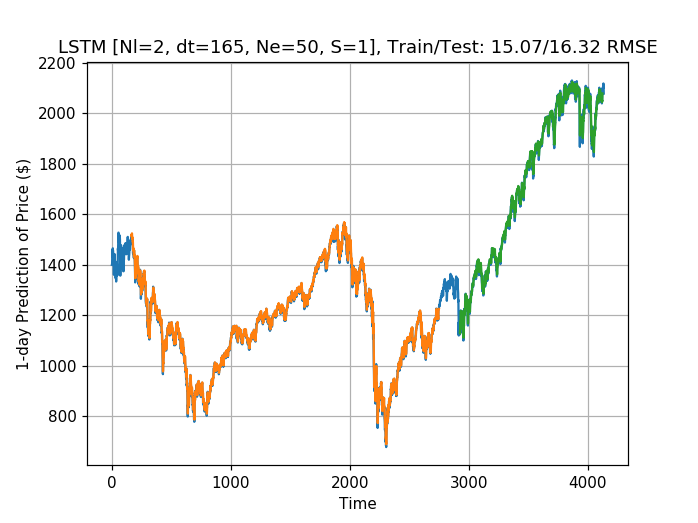

<IPython.core.display.Javascript object>


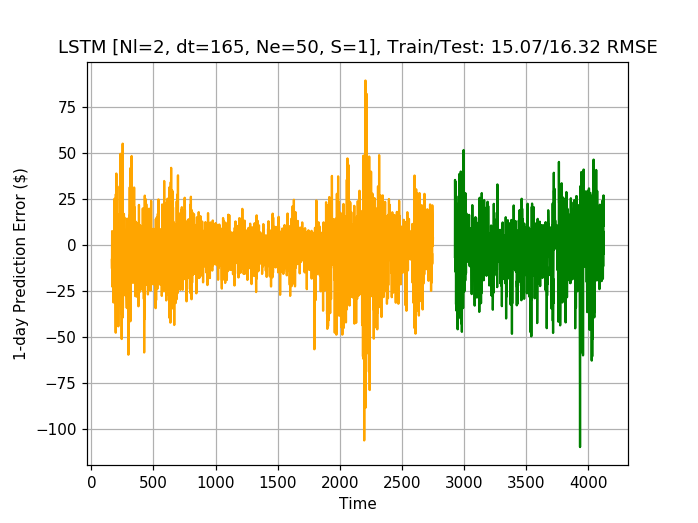

(15.074657432024372, 16.320538346013898)

In [110]:
stateful=True
nlayer=2         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=165
n_epoch=50;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful,verbose=2)

=== make_bmodel_2: n_layer= 2 , dt_back= 165 , n_epoch= 30 , Nb= 11  ===
Epoch 1/30
32s - loss: 0.0022
Epoch 2/30
30s - loss: 4.5485e-04
Epoch 3/30
30s - loss: 4.0394e-04
Epoch 4/30
30s - loss: 3.6768e-04
Epoch 5/30
30s - loss: 3.4073e-04
Epoch 6/30
30s - loss: 3.1911e-04
Epoch 7/30
30s - loss: 2.8763e-04
Epoch 8/30
30s - loss: 2.6952e-04
Epoch 9/30
30s - loss: 2.8801e-04
Epoch 10/30
30s - loss: 2.4308e-04
Epoch 11/30
30s - loss: 2.3354e-04
Epoch 12/30
30s - loss: 2.1687e-04
Epoch 13/30
30s - loss: 2.4467e-04
Epoch 14/30
30s - loss: 2.2936e-04
Epoch 15/30
30s - loss: 1.9250e-04
Epoch 16/30
30s - loss: 1.9104e-04
Epoch 17/30
30s - loss: 1.9377e-04
Epoch 18/30
30s - loss: 1.9913e-04
Epoch 19/30
30s - loss: 1.8101e-04
Epoch 20/30
30s - loss: 1.7837e-04
Epoch 21/30
30s - loss: 1.8699e-04
Epoch 22/30
30s - loss: 1.8988e-04
Epoch 23/30
30s - loss: 1.8591e-04
Epoch 24/30
30s - loss: 1.7427e-04
Epoch 25/30
30s - loss: 1.7404e-04
Epoch 26/30
32s - loss: 1.7800e-04
Epoch 27/30
33s - loss: 1.7951

<IPython.core.display.Javascript object>


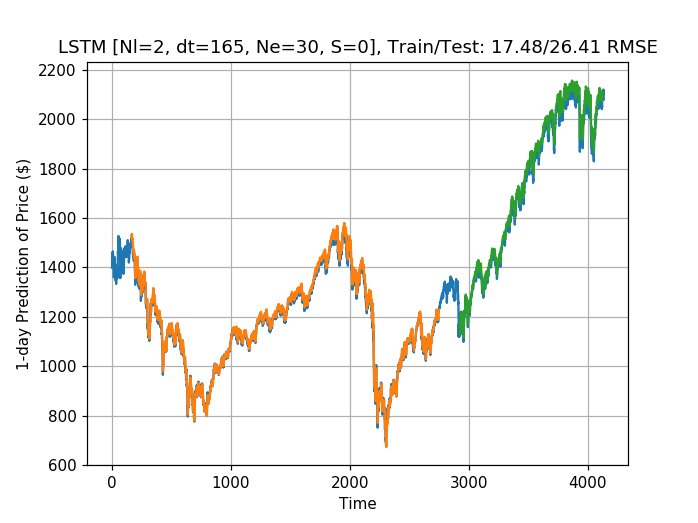

<IPython.core.display.Javascript object>


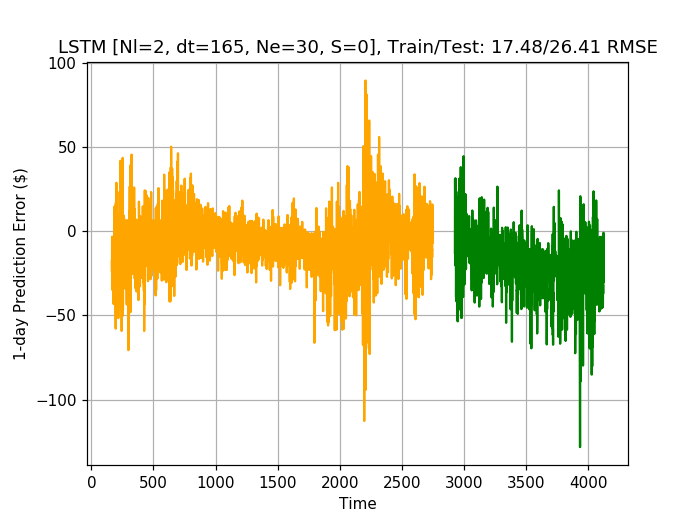

(17.478081673653882, 26.410678157417284)

In [115]:
# now let us turn off memory in prev model
stateful=False;    #True;   #
nlayer=2         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=165
n_epoch=30;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful,verbose=2)

=== make_bmodel_2: n_layer= 2 , dt_back= 165 , n_epoch= 50 , Nb= 11  ===
Epoch 1/50
33s - loss: 0.0026
Epoch 2/50
30s - loss: 4.2275e-04
Epoch 3/50
30s - loss: 4.1084e-04
Epoch 4/50
30s - loss: 3.5972e-04
Epoch 5/50
30s - loss: 3.4441e-04
Epoch 6/50
30s - loss: 3.3287e-04
Epoch 7/50
30s - loss: 2.9266e-04
Epoch 8/50
30s - loss: 2.8059e-04
Epoch 9/50
30s - loss: 2.9226e-04
Epoch 10/50
30s - loss: 2.7131e-04
Epoch 11/50
30s - loss: 2.4393e-04
Epoch 12/50
30s - loss: 2.4284e-04
Epoch 13/50
30s - loss: 2.1659e-04
Epoch 14/50
30s - loss: 2.1112e-04
Epoch 15/50
30s - loss: 2.1974e-04
Epoch 16/50
30s - loss: 1.8385e-04
Epoch 17/50
30s - loss: 1.9778e-04
Epoch 18/50
30s - loss: 2.0057e-04
Epoch 19/50
30s - loss: 2.0215e-04
Epoch 20/50
31s - loss: 1.8092e-04
Epoch 21/50
30s - loss: 1.7578e-04
Epoch 22/50
30s - loss: 1.7409e-04
Epoch 23/50
30s - loss: 1.9085e-04
Epoch 24/50
30s - loss: 1.5979e-04
Epoch 25/50
30s - loss: 1.7473e-04
Epoch 26/50
30s - loss: 1.6318e-04
Epoch 27/50
30s - loss: 1.7127

<IPython.core.display.Javascript object>


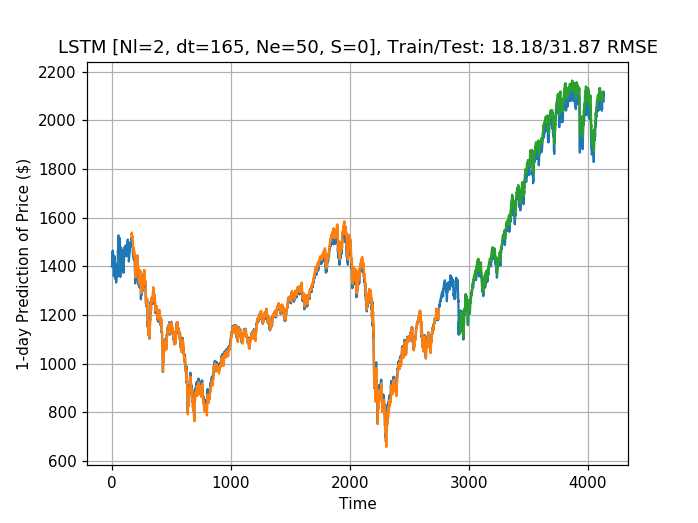

<IPython.core.display.Javascript object>


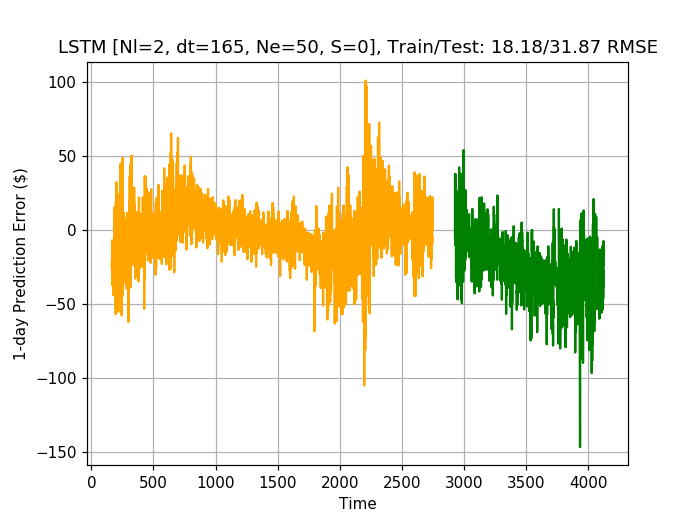

(18.18489903968315, 31.87018773267464)

In [116]:
# we may need more time to train the model, increase n_epoch
stateful=False;    #True;   #
nlayer=2         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=165
n_epoch=50;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful,verbose=2)

=== make_bmodel_3: n_layer= 3 , dt_back= 165 , n_epoch= 50 , Nb= 11  ===
Epoch 1/50
50s - loss: 0.0028
Epoch 2/50
47s - loss: 6.5970e-04
Epoch 3/50
47s - loss: 5.6202e-04
Epoch 4/50
47s - loss: 5.2484e-04
Epoch 5/50
47s - loss: 4.3985e-04
Epoch 6/50
47s - loss: 3.8164e-04
Epoch 7/50
47s - loss: 3.9594e-04
Epoch 8/50
47s - loss: 3.3772e-04
Epoch 9/50
47s - loss: 3.1403e-04
Epoch 10/50
47s - loss: 3.2634e-04
Epoch 11/50
47s - loss: 2.7335e-04
Epoch 12/50
47s - loss: 2.7229e-04
Epoch 13/50
47s - loss: 2.6857e-04
Epoch 14/50
47s - loss: 2.7792e-04
Epoch 15/50
47s - loss: 2.6590e-04
Epoch 16/50
47s - loss: 2.6020e-04
Epoch 17/50
47s - loss: 2.3757e-04
Epoch 18/50
47s - loss: 2.1942e-04
Epoch 19/50
47s - loss: 2.3050e-04
Epoch 20/50
47s - loss: 2.3525e-04
Epoch 21/50
47s - loss: 2.1787e-04
Epoch 22/50
47s - loss: 2.4003e-04
Epoch 23/50
47s - loss: 2.1284e-04
Epoch 24/50
47s - loss: 2.2017e-04
Epoch 25/50
47s - loss: 2.3527e-04
Epoch 26/50
47s - loss: 2.1392e-04
Epoch 27/50
47s - loss: 2.2737

<IPython.core.display.Javascript object>


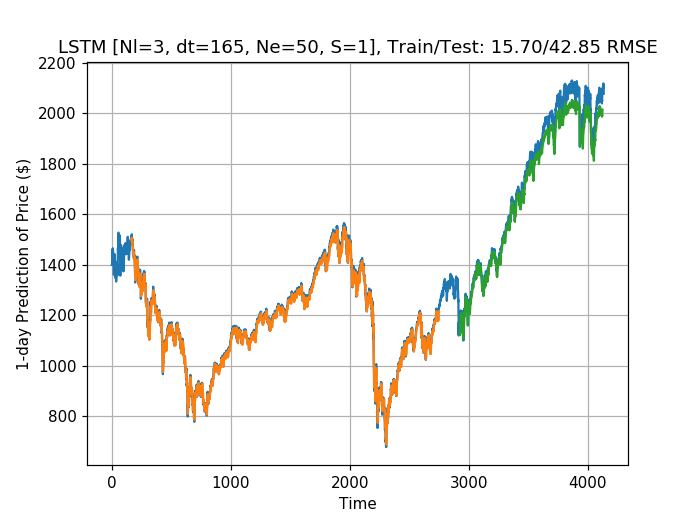

<IPython.core.display.Javascript object>


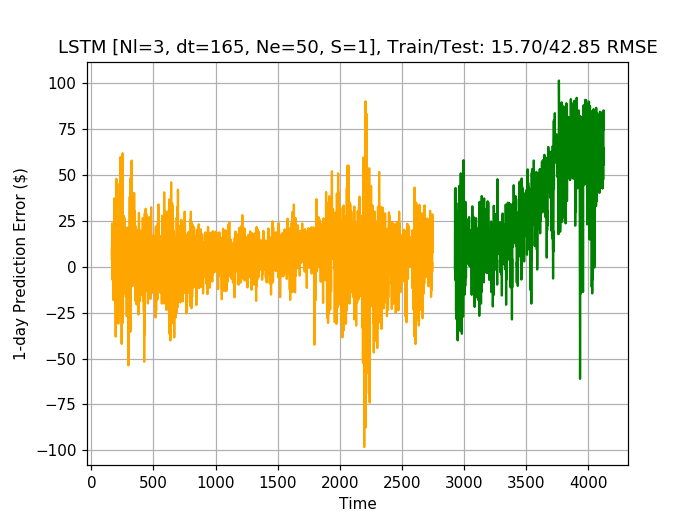

(15.703872807374301, 42.853777736658685)

In [114]:
stateful=True
nlayer=3         # [:-5]   p_t[:-10]  train[:-5]  [:-5]
dt_back=165
n_epoch=50;   #15;    # 5;   #

train_plot_model(p_t,eval('make_bmodel_' + str(nlayer)),nlayer,train,test,dt_back,n_epoch,batch_size,stateful,verbose=2)